Sample: 100%|███████████████████████████████████████| 1000/1000 [00:58, 17.13it/s, step size=2.42e-02, acc. prob=0.917]


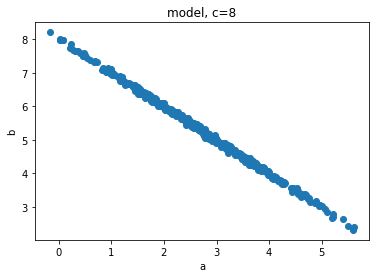

loss @ 0 20.755035519599915
loss @ 100 4.240923851728439
loss @ 200 3.44933220744133
loss @ 300 3.1995976120233536
loss @ 400 2.712731257081032
loss @ 500 3.7724921852350235
loss @ 600 3.2149334847927094
loss @ 700 3.2393345087766647
loss @ 800 4.915243417024612
loss @ 900 3.348587065935135
loss @ 1000 3.877919927239418
loss @ 1100 2.9313638657331467
loss @ 1200 4.265357106924057
loss @ 1300 2.974001169204712
loss @ 1400 3.513400360941887
loss @ 1500 2.754672333598137
loss @ 1600 3.3117814511060715
loss @ 1700 2.6679604947566986
loss @ 1800 3.6440583616495132
loss @ 1900 3.036169096827507
loss @ 2000 2.6975371539592743
loss @ 2100 2.5738050639629364
loss @ 2200 3.621424689888954
loss @ 2300 2.8193032145500183
loss @ 2400 3.7185331732034683
loss @ 2500 2.7341298907995224
loss @ 2600 3.4699507653713226
loss @ 2700 2.9834603518247604
loss @ 2800 3.243569001555443
loss @ 2900 2.7812241911888123
loss @ 3000 3.3277436047792435
loss @ 3100 3.4427279233932495
loss @ 3200 2.7332453429698944
los

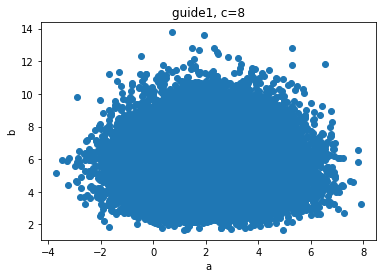

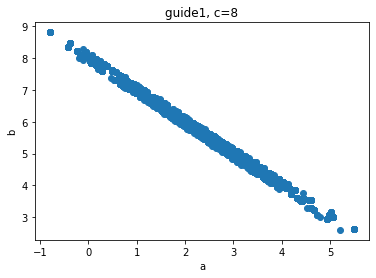

loss @ 0 4.733905375003815
loss @ 100 4.195483684539795
loss @ 200 2.462689593434334
loss @ 300 1.0506932064890862
loss @ 400 1.715861901640892
loss @ 500 3.8729343116283417
loss @ 600 3.763697028160095
loss @ 700 3.713254898786545
loss @ 800 3.0874185264110565
loss @ 900 2.8679063990712166
loss @ 1000 0.8639990406809375
loss @ 1100 0.5994727965007769
loss @ 1200 0.6206822232343256
loss @ 1300 1.0905385534279048
loss @ 1400 -0.21875091549009085
loss @ 1500 0.8039355874061584
loss @ 1600 1.348897535353899
loss @ 1700 2.0784409195184708
loss @ 1800 0.3880910286679864
loss @ 1900 -0.22407313250005245
loss @ 2000 0.45772542292252183
loss @ 2100 0.3106029503978789
loss @ 2200 -0.16715019685216248
loss @ 2300 0.6122543141245842
loss @ 2400 0.07707406452391297
loss @ 2500 -0.2788839817076223
loss @ 2600 0.6643004363868386
loss @ 2700 0.2923196256160736
loss @ 2800 0.3906981945037842
loss @ 2900 0.934502262622118
loss @ 3000 -0.07050531543791294
loss @ 3100 -0.20845268946141005
loss @ 3200 0.0

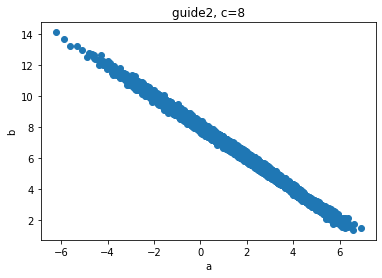

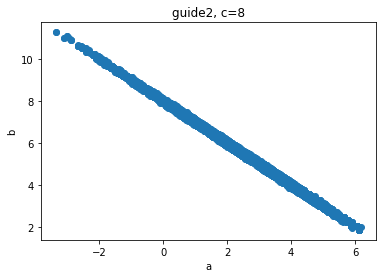

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyro
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS

def make_plot(x, y, main):
    plt.plot(x, y, "o")
    plt.title(main)
    plt.xlabel("a")
    plt.ylabel("b")
    plt.show()
    
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal" or t == "gamma":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 0)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "gamma":
            return self.softplus(self.loc_layer(hid)), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)
    
g1_nnb_c = simpleNN(t="gamma")
g1_nna_c = simpleNN()
g2_nnb_c = simpleNN(t="gamma")
g2_nna_c = simpleNN(input_size=2)

guide1_a = []
guide1_b = []
guide2_a = []
guide2_b = []
    
def model(observations={"c" : 0}):
    a = pyro.sample("a", dist.Normal(0, 2))
    b = pyro.sample("b", dist.Gamma(8, 2))
    c = pyro.sample("c", dist.Normal(a + b, 0.05), obs=observations["c"])
    return c
    #return {"a" : a, "b" : b, "c" : c}

def guide1(observations={"c" : 0}):
    pyro.module("g1_nnb_c", g1_nnb_c)
    pyro.module("g1_nna_c", g1_nna_c)
    c = observations["c"]
    b_alpha, b_beta = g1_nnb_c([c])
    b = pyro.sample("b", dist.Gamma(b_alpha, b_beta))
    a_mu, a_sig = g1_nna_c([c])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide1_a.append(a.detach().numpy())
#     guide1_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()

def guide2(observations={"c" : 0}):
    pyro.module("g2_nnb_c", g2_nnb_c)
    pyro.module("g2_nna_c", g2_nna_c)
    c = observations["c"]
    b_alpha, b_beta = g2_nnb_c([c])
    b = pyro.sample("b", dist.Gamma(b_alpha, b_beta))
    a_mu, a_sig = g2_nna_c([c, b])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide2_a.append(a.detach().numpy())
#     guide2_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()
    
c = torch.tensor(8.)
mcmc_num_samples = 500
num_samples = 50000
num_inference_samples = 10000

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=mcmc_num_samples)
mcmc.run({"c": c})
model_samples = mcmc.get_samples()
model_a = model_samples["a"].detach().numpy()
model_b = model_samples["b"].detach().numpy()
make_plot(model_a, model_b, main="model, c="+str(int(c)))

def run_guide_csis(guide):
    pyro.clear_param_store()
    global g1_nnb_c, g1_nna_c, g2_nnb_c, g2_nna_c
    g1_nnb_c = simpleNN(t="gamma")
    g1_nna_c = simpleNN()
    g2_nnb_c = simpleNN(t="gamma")
    g2_nna_c = simpleNN(input_size=2)
    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = Adam(adam_params)
    n_steps = 10000
    csis = pyro.infer.CSIS(model, guide, optimizer, num_inference_samples=num_inference_samples)

    for step in range(n_steps):
        loss = csis.step()
        if step % 100 == 0:
            print("loss @ " + str(step), loss)
    posterior = csis.run(observations={"c": c})
    marginal = pyro.infer.EmpiricalMarginal(posterior, ["a", "b"])
    csis_samples_a = []
    csis_samples_b = []
    for _ in range(num_samples):
        sample = marginal()
        a = float(sample[0])
        b = float(sample[1])
        csis_samples_a.append(a)
        csis_samples_b.append(b)
    return csis_samples_a, csis_samples_b

guide1_a_is, guide1_b_is = run_guide_csis(guide1)
for _ in range(num_samples):
    a, b =guide1({"c" : c})
    guide1_a.append(a)
    guide1_b.append(b)
make_plot(guide1_a, guide1_b, main="guide1, c="+str(int(c)))
make_plot(guide1_a_is, guide1_b_is, main="guide1, c="+str(int(c)))

guide2_a_is, guide2_b_is = run_guide_csis(guide2)
for _ in range(num_samples):
    a, b =guide2({"c" : c})
    guide2_a.append(a)
    guide2_b.append(b)
make_plot(guide2_a, guide2_b, main="guide2, c="+str(int(c)))
make_plot(guide2_a_is, guide2_b_is, main="guide2, c="+str(int(c)))
